In [ ]:
!pip install -q transformers==4.37.2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import sklearn as sk
import os
import nltk
from nltk.data import find
import pandas as pd
import gc

import matplotlib.pyplot as plt

import re

In [ ]:
## Load datasets
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
model_checkpoints_path = '/content/drive/My Drive/ds266proj/model_checkpoints'

# Read data from to Google Drive
hs_all_data = pd.read_csv('/content/drive/My Drive/ds266proj/hs_cards_data_text.csv')
nr_all_data = pd.read_csv('/content/drive/My Drive/ds266proj/nr_cards_data_text.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## CODE FOR TRAIN AND TEST SPLITS
##===========================================================

def splitTrainTest(dataset,
                   label,
                   test_ratio = 0.3):

  # Set up the modeling dataset and classification label
  modeling_df = dataset.copy()
  classes = modeling_df[label].unique().tolist()
  print(f"Label classes: {classes}")
  # Convert the label to a numeric value
  modeling_df.loc[:, label] = modeling_df[label].map(classes.index)

  # Split into training and test data
  np.random.seed(2319)
  test_indices = np.random.rand(len(modeling_df)) < test_ratio
  print("{} examples in training, {} examples for testing.".format(
    len(modeling_df[~test_indices]), len(modeling_df[test_indices])))

  return modeling_df[~test_indices], modeling_df[test_indices]

hs_train, hs_test = splitTrainTest(hs_all_data, label = 'classes')
nr_train, nr_test = splitTrainTest(nr_all_data, label = 'faction_code')

Label classes: ['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL']
5234 examples in training, 2291 examples for testing.
Label classes: ['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch']
1495 examples in training, 628 examples for testing.


In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import logging
logging.set_verbosity_error()

In [ ]:
MAX_SEQ_LENGTH = 512
checkpoint = 'roberta-base'

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
## Simplistic RoBERTa model creation
def create_roberta_classification_model(roberta_model,
                                     checkpoint_name = 'DEFAULT',
                                     model_checkpoints_path = '/content/drive/My Drive/ds266proj/model_checkpoints/',
                                     num_train_layers = 0,
                                     num_classes = 12,
                                     retrain_layers = None,
                                     hidden_size = 200,
                                     dropout = 0.3,
                                     chkpt_period = 1,
                                     learning_rate = 0.00005):

    if num_train_layers == 0:
        # Freeze all layers of pre-trained RoBERTa model
        roberta_model.trainable = False
    elif num_train_layers == 12 and retrain_layers is None:
        # Train all layers of the RoBERTa model
        roberta_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        if retrain_layers is not None:
          print('retrain layers: ', retrain_layers)
        else:
          retrain_layers = []
          for retrain_layer_number in range(num_train_layers):
              layer_code = '_' + str(11 - retrain_layer_number)
              retrain_layers.append(layer_code)
          print('retrain layers: ', retrain_layers)

        for w in roberta_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                # print('freezing: ', w.name)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    ## Set up the RoBERTa model; this will use the CLS token input
    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}
    roberta_out = roberta_model(roberta_inputs)
    print(roberta_out[0])
    cls_token = roberta_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics='accuracy')

    ## Set up the checkpointing for the model
    checkpoint_filepath = model_checkpoints_path + checkpoint_name + '_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)

    return classification_model, model_checkpoint_callback

In [ ]:
## Set up the model inputs
def genRoBERTaInputs(train_data, test_data, desc_field, label_field, return_tensors):
  # Tokenize the training and test data
  x_train = roberta_tokenizer(train_data[desc_field].tolist(),
                           padding = "max_length",
                           truncation = True,
                           max_length = MAX_SEQ_LENGTH,
                           return_tensors = return_tensors)
  x_test = roberta_tokenizer(test_data[desc_field].tolist(),
                          padding = "max_length",
                          truncation = True,
                          max_length = MAX_SEQ_LENGTH,
                          return_tensors = return_tensors)
  # Return array versions of the labels
  y_train = np.array(train_data[label_field].tolist())
  y_test = np.array(test_data[label_field].tolist())
  # Return all data
  return x_train, x_test, y_train, y_test

# Create the datasets
x_hs_train_tf, x_hs_test_tf, y_hs_train_tf, y_hs_test_tf = genRoBERTaInputs(hs_train, hs_test, 'description', 'classes', 'tf')
x_nr_train_tf, x_nr_test_tf, y_nr_train_tf, y_nr_test_tf = genRoBERTaInputs(nr_train, nr_test, 'description', 'faction_code', 'tf')

### Running Models

In [ ]:
tf_roberta_model = TFRobertaModel.from_pretrained(checkpoint)
## RoBERTa runs out of memory even with a batch size of 16, and the difference between 8 and 12 was not huge for BERT
roberta_model_hs, roberta_model_hs_chkpt = create_roberta_classification_model(tf_roberta_model, num_classes = 12, checkpoint_name = 'RoBERTa_full_train_HS', num_train_layers=8)

retrain layers:  ['_11', '_10', '_9', '_8', '_7', '_6', '_5', '_4']
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_roberta_model'")


In [ ]:
## Train the model
roberta_model_hs_history = roberta_model_hs.fit(
    [x_hs_train_tf.input_ids, x_hs_train_tf.attention_mask],
    y_hs_train_tf,
    validation_data=([x_hs_test_tf.input_ids, x_hs_test_tf.attention_mask], y_hs_test_tf),
    batch_size=16,
    epochs=8,
    callbacks=[roberta_model_hs_chkpt]
)

Epoch 1/8


328/328 [==============================] - 230s 580ms/step - loss: 2.4654 - accuracy: 0.1148 - val_loss: 2.2140 - val_accuracy: 0.2239
Epoch 2/8
328/328 [==============================] - 198s 605ms/step - loss: 1.9923 - accuracy: 0.3250 - val_loss: 1.7239 - val_accuracy: 0.4138
Epoch 3/8
328/328 [==============================] - 198s 604ms/step - loss: 1.5989 - accuracy: 0.4566 - val_loss: 1.4131 - val_accuracy: 0.5255
Epoch 4/8
328/328 [==============================] - 198s 605ms/step - loss: 1.2991 - accuracy: 0.5562 - val_loss: 1.2286 - val_accuracy: 0.5897
Epoch 5/8
328/328 [==============================] - 198s 605ms/step - loss: 1.0834 - accuracy: 0.6209 - val_loss: 1.1068 - val_accuracy: 0.6364
Epoch 6/8
328/328 [==============================] - 198s 605ms/step - loss: 0.9119 - accuracy: 0.6924 - val_loss: 1.1059 - val_accuracy: 0.6569
Epoch 7/8
328/328 [==============================] - 199s 606ms/step - loss: 0.7318 - accuracy: 0.7528 - val_loss: 1.0047 - val_accuracy: 0.

In [ ]:
tf_roberta_model = TFRobertaModel.from_pretrained(checkpoint)
## RoBERTa runs out of memory even with a batch size of 16, and the difference between 8 and 12 was not huge for BERT
roberta_model_nr, roberta_model_nr_chkpt = create_roberta_classification_model(tf_roberta_model, num_classes = 9, checkpoint_name = 'RoBERTa_full_train_NR', num_train_layers=8)

retrain layers:  ['_11', '_10', '_9', '_8', '_7', '_6', '_5', '_4']
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_roberta_model'")


In [ ]:
roberta_model_nr_history = roberta_model_nr.fit(
    [x_nr_train_tf.input_ids, x_nr_train_tf.attention_mask],
    y_nr_train_tf,
    validation_data=([x_nr_test_tf.input_ids, x_nr_test_tf.attention_mask], y_nr_test_tf),
    batch_size=16,
    epochs=8,
    callbacks=[roberta_model_nr_chkpt]
)

Epoch 1/8


94/94 [==============================] - 92s 638ms/step - loss: 2.1489 - accuracy: 0.1612 - val_loss: 1.6285 - val_accuracy: 0.2723
Epoch 2/8
94/94 [==============================] - 57s 608ms/step - loss: 1.6907 - accuracy: 0.2662 - val_loss: 1.3956 - val_accuracy: 0.3822
Epoch 3/8
94/94 [==============================] - 57s 606ms/step - loss: 1.3179 - accuracy: 0.4254 - val_loss: 1.1666 - val_accuracy: 0.4904
Epoch 4/8
94/94 [==============================] - 56s 595ms/step - loss: 1.1467 - accuracy: 0.4963 - val_loss: 1.0524 - val_accuracy: 0.5334
Epoch 5/8
94/94 [==============================] - 55s 582ms/step - loss: 1.0330 - accuracy: 0.5779 - val_loss: 0.9763 - val_accuracy: 0.5955
Epoch 6/8
94/94 [==============================] - 58s 614ms/step - loss: 0.9613 - accuracy: 0.6033 - val_loss: 0.9750 - val_accuracy: 0.6083
Epoch 7/8
94/94 [==============================] - 57s 609ms/step - loss: 0.8291 - accuracy: 0.6696 - val_loss: 0.9541 - val_accuracy: 0.6210
Epoch 8/8
94/94 

### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tf_roberta_model = TFRobertaModel.from_pretrained(checkpoint)
nr_model_path = '/content/drive/My Drive/ds266proj/model_checkpoints/RoBERTa_full_train_NR_weights.08-0.59.hdf5'
roberta_model_nr, _ = create_roberta_classification_model(tf_roberta_model, num_classes = 9, checkpoint_name = 'LOAD_MODEL', num_train_layers=12, chkpt_period = 2)
roberta_model_nr.load_weights(nr_model_path)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_roberta_model_3/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_roberta_model_3'")


In [ ]:
tf_roberta_model = TFRobertaModel.from_pretrained(checkpoint)
hs_model_path = '/content/drive/My Drive/ds266proj/model_checkpoints/RoBERTa_full_train_HS_weights.08-0.73.hdf5'
roberta_model_hs, _ = create_roberta_classification_model(tf_roberta_model, num_classes = 12, checkpoint_name = 'LOAD_MODEL', num_train_layers=12, chkpt_period = 2)
roberta_model_hs.load_weights(hs_model_path)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_roberta_model_2/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_roberta_model_2'")


In [ ]:
## HS MODEL
##--------------------------------------------------
batch_size = 16

all_predictions = []
all_probabilities = []

## Too Large to do all at once so have to generate predictions in batchs
for i in range(0, x_hs_test_tf['input_ids'].shape[0], batch_size):
    batch_input_data = {
        'input_ids_layer': x_hs_test_tf['input_ids'][i:i + batch_size],
        'attention_mask_layer': x_hs_test_tf['attention_mask'][i:i + batch_size]
    }

    outputs = roberta_model_hs(batch_input_data)
    predicted_labels = np.argmax(outputs, axis=1)
    all_predictions.extend(predicted_labels)

# Convert predictions and probabilities to numpy arrays
all_predictions_hs = np.array(all_predictions)

accuracy = accuracy_score(y_hs_test_tf, all_predictions_hs)
precision = precision_score(y_hs_test_tf, all_predictions_hs, average='weighted')
recall = recall_score(y_hs_test_tf, all_predictions_hs, average='weighted')

print(f'Hearthstone RoBERTa Accuracy: {accuracy:.4f}')
print(f'Hearthstone RoBERTa Precision: {precision:.4f}')
print(f'Hearthstone RoBERTa Recall: {recall:.4f}')

Hearthstone RoBERTa Accuracy: 0.7302
Hearthstone RoBERTa Precision: 0.7388
Hearthstone RoBERTa Recall: 0.7302


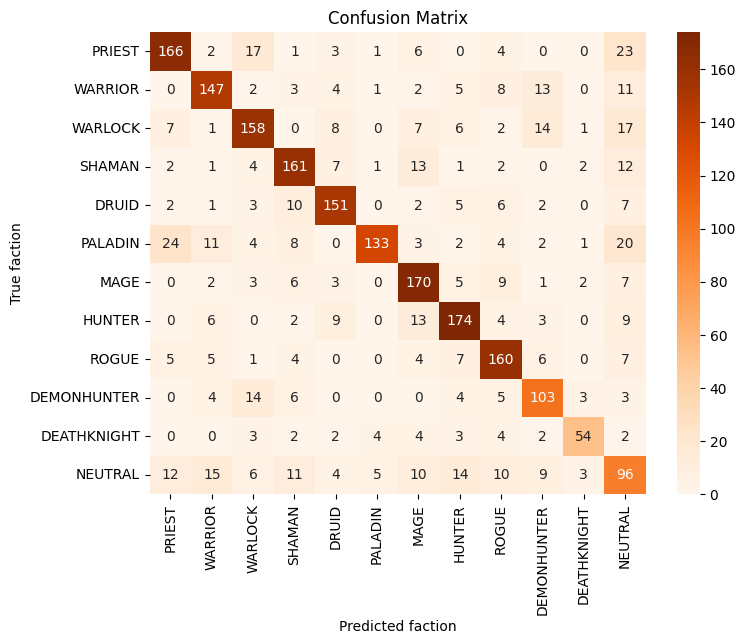

In [ ]:
cm = confusion_matrix(y_hs_test_tf, all_predictions_hs)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges',
            xticklabels=['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL'],
            yticklabels=['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL'])
plt.xlabel('Predicted faction')
plt.ylabel('True faction')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## NR MODEL
##--------------------------------------------------
batch_size = 16

all_predictions = []
all_probabilities = []

## Too Large to do all at once so have to generate predictions in batchs
for i in range(0, x_nr_test_tf['input_ids'].shape[0], batch_size):
    batch_input_data = {
        'input_ids_layer': x_nr_test_tf['input_ids'][i:i + batch_size],
        'attention_mask_layer': x_nr_test_tf['attention_mask'][i:i + batch_size]
    }

    outputs = roberta_model_nr(batch_input_data)
    predicted_labels = np.argmax(outputs, axis=1)
    all_predictions.extend(predicted_labels)

# Convert predictions and probabilities to numpy arrays
all_predictions_nr = np.array(all_predictions)

accuracy = accuracy_score(y_nr_test_tf, all_predictions_nr)
precision = precision_score(y_nr_test_tf, all_predictions_nr, average='weighted')
recall = recall_score(y_nr_test_tf, all_predictions_nr, average='weighted')

print(f'NetRunner RoBERTa Accuracy: {accuracy:.4f}')
print(f'NetRunner RoBERTa Precision: {precision:.4f}')
print(f'NetRunner RoBERTa Recall: {recall:.4f}')

NetRunner RoBERTa Accuracy: 0.5939
NetRunner RoBERTa Precision: 0.6323
NetRunner RoBERTa Recall: 0.5939


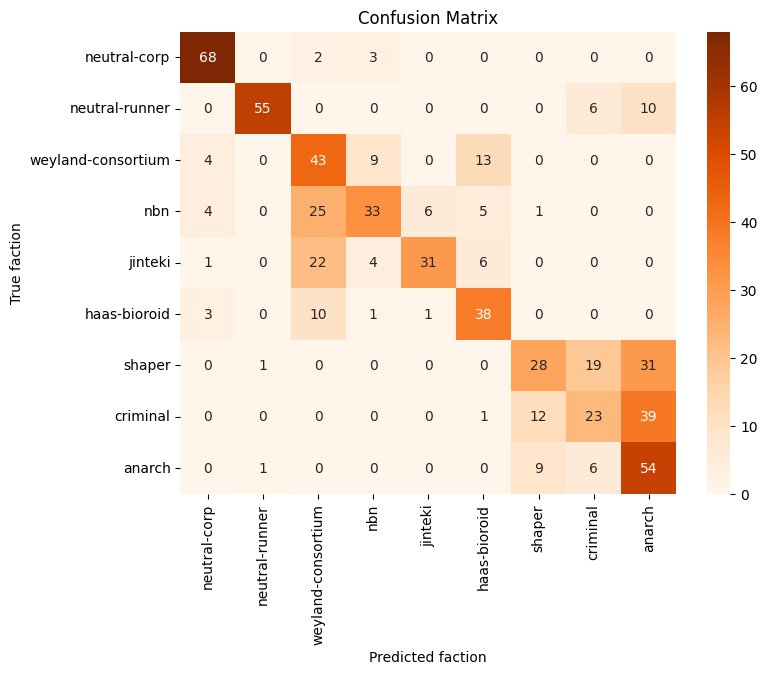

In [ ]:
cm = confusion_matrix(y_nr_test_tf, all_predictions_nr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges',
            xticklabels=['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch'],
            yticklabels=['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch'])
plt.xlabel('Predicted faction')
plt.ylabel('True faction')
plt.title('Confusion Matrix')
plt.show()